# `MonotonicSplineEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import cProfile
import math
import pstats
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 18  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 18 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTA


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

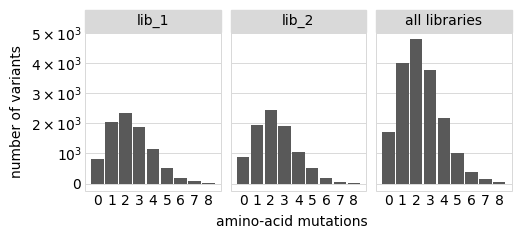

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

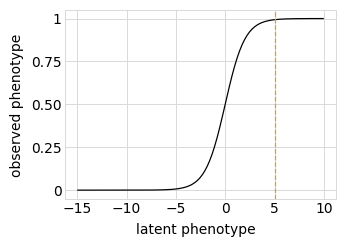

In [10]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

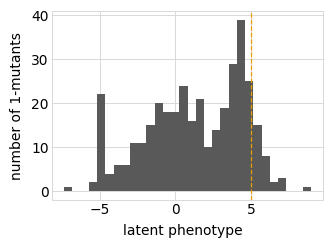

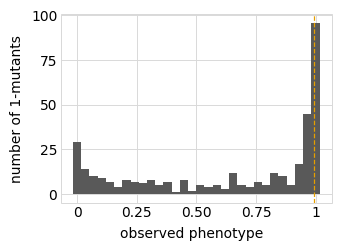

In [11]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

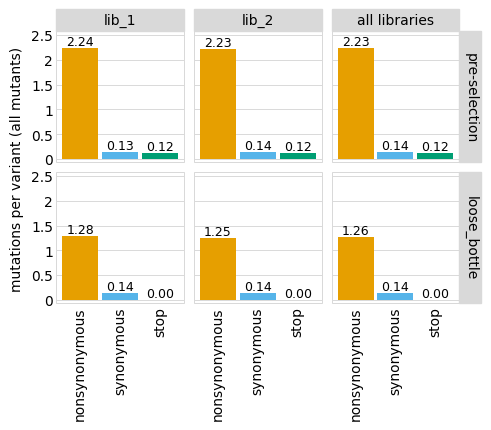

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,20160471,9000000,2.240052
1,lib_1,pre-selection,synonymous,1190230,9000000,0.132248
2,lib_1,pre-selection,stop,1081015,9000000,0.120113
3,lib_1,loose_bottle,nonsynonymous,11533670,9000000,1.281519
4,lib_1,loose_bottle,synonymous,1222977,9000000,0.135886
5,lib_1,loose_bottle,stop,4300,9000000,0.000478
6,lib_2,pre-selection,nonsynonymous,20028816,9000000,2.225424
7,lib_2,pre-selection,synonymous,1275581,9000000,0.141731
8,lib_2,pre-selection,stop,1060811,9000000,0.117868
9,lib_2,loose_bottle,nonsynonymous,11206791,9000000,1.245199


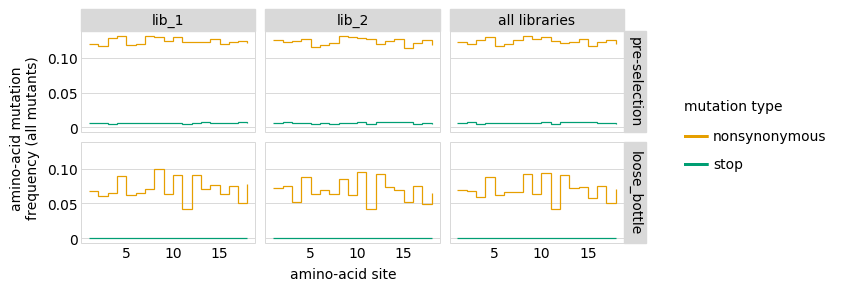

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

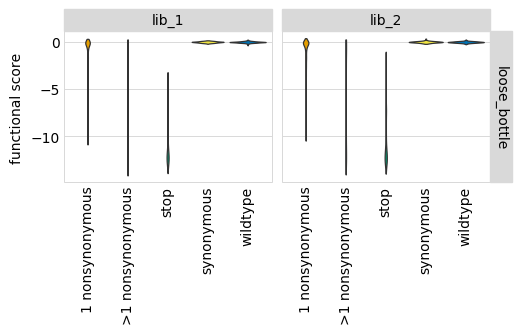

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [20]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 360


Now initialize the model:

In [21]:
spline_model = dms_variants.globalepistasis.MonotonicSplineEpistasis(binarymap)

Look at some model attributes:

In [22]:
spline_model.nparams

368

In [23]:
spline_model.epistasis_HOC

1.0

In [24]:
round(spline_model.loglik)

-959253.0

In [25]:
spline_model.latent_phenotype_wt

0.0

In [26]:
for key, val in spline_model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -14.18
alpha_1: 2.92
alpha_2: 2.92
alpha_3: 2.92
alpha_4: 2.92
alpha_5: 2.92


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [27]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Fit model
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [28]:
spline_model._fit_latent_leastsquares()
spline_model._prescale_params()

Re-check the gradients:

In [29]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Print model parameters after this "partial" fitting:

In [30]:
round(spline_model.loglik)

-52098.0

In [31]:
round(spline_model.epistasis_HOC, 3)

2.909

In [32]:
round(spline_model.latent_phenotype_wt, 3)

0.899

Now fit the model by maximum likelihood, also profiling [as here](https://stackoverflow.com/a/1584468):

In [33]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler = cProfile.Profile()
optres = profiler.runcall(spline_model.fit)
optres = spline_model.fit()
print(f"Fitting took {time.time() - start:.3f} seconds")
print(f"Iterations: {optres.nit}.\n"
      f"Function evaluations: {optres.nfev}\n"
      f"Termination message: {optres.message}")

Fitting took 42.878 seconds
Iterations: 666.
Function evaluations: 764
Termination message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Look at some of the model parameters after optimization:

In [34]:
round(spline_model.loglik)

-865.0

In [35]:
round(spline_model.epistasis_HOC, 3)

0.005

In [36]:
round(spline_model.latent_phenotype_wt, 3)

0.0

In [37]:
spline_model._mesh.round(2)

array([-7.99, -5.56, -3.13, -0.7 ])

In [38]:
spline_model.alpha_ms.round(2)

array([ 0.  ,  0.  ,  0.  , 12.73,  0.02])

In [39]:
round(spline_model.c_alpha, 2)

-12.79

Plot correlation of actual functional scores with latent and observed phenotypes:


Correlation for latent:
R = 0.913, P = 0

Correlation for observed:
R = 0.994, P = 0


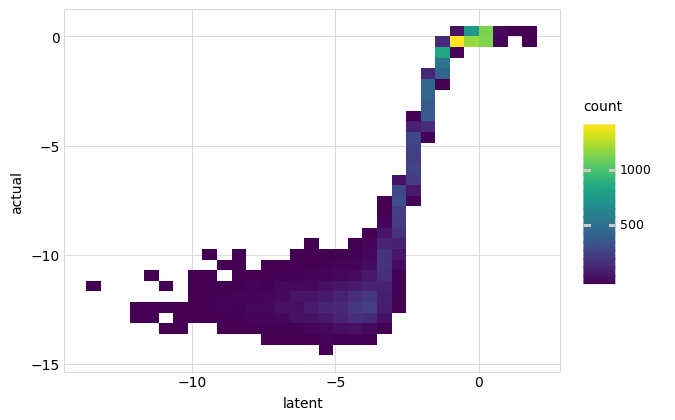

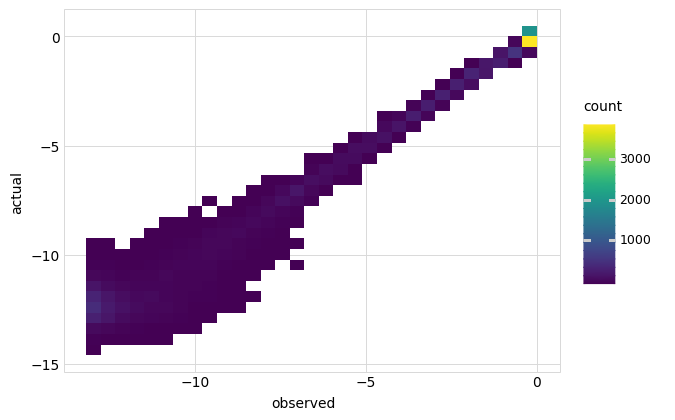

In [40]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, phenotype)
        )
    print(f"\nCorrelation for {phenotype}:\nR = {r:.3f}, P = {p:.2g}")

    _ = (ggplot(df, aes(phenotype, 'actual')) +
         geom_bin2d()
         ).draw()

Plot latent versus observed phenotypes:

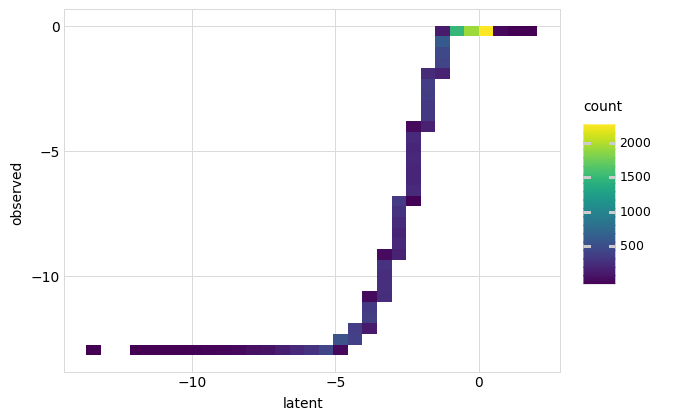

In [41]:
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

Look at profiling results:

In [42]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler.dump_stats(f.name)
    f.flush()
    stats = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats.sort_stats(stat).print_stats(20))

Mon Oct 28 13:40:06 2019    /var/folders/fc/7sw280c13755gkvcsqlhlrfc0000gp/T/tmpkqszgp5m

         10011229 function calls (9014713 primitive calls) in 26.525 seconds

   Ordered by: cumulative time
   List reduced from 340 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   26.525   26.525 globalepistasis.py:631(fit)
        1    0.000    0.000   26.484   26.484 _minimize.py:42(minimize)
        1    0.094    0.094   26.484   26.484 lbfgsb.py:211(_minimize_lbfgsb)
     1071    0.006    0.000   26.386    0.025 lbfgsb.py:284(func_and_grad)
513661/3214    0.808    0.000   21.691    0.007 methodtools.py:31(__call__)
     3214    0.678    0.000   21.668    0.007 ispline.py:247(_calculate_Itotal_or_dItotal)
    21410    1.550    0.000   19.249    0.001 ispline.py:673(_calculate_I_or_dI)
     1071    0.003    0.000   16.080    0.015 optimize.py:324(function_wrapper)
     1071    0.003    0.000   16.077    0.015 

## Examine single mutants
Correlation of predicted and actual predicted latent effects.
Get a data frame of the latent effects of all single mutations:

In [43]:
singles_df = spline_model.latent_effects_df
singles_df.head().round(3)

,mutation,latent_effect
0,R1*,-2.618
1,R1A,-1.809
2,R1C,-0.250
3,R1D,-0.404
4,R1E,-2.344


Add the true latent effects from the simulator:

In [44]:
singles_df = (
    singles_df
    .rename(columns={'mutation': 'aa_substitutions'})
    .assign(true_latent_effect=lambda x: x['aa_substitutions'].map(phenosimulator.muteffects))
    )
singles_df.head().round(3)

,aa_substitutions,latent_effect,true_latent_effect
0,R1*,-2.618,-10.000
1,R1A,-1.809,-7.005
2,R1C,-0.250,-0.949
3,R1D,-0.404,-1.606
4,R1E,-2.344,-9.136


Now add the predicted and true latent and observed phenotypes:

In [45]:
singles_df = spline_model.add_phenotypes_to_df(singles_df)

singles_df = (
    singles_df
    .assign(true_latent_phenotype=lambda x: x.apply(phenosimulator.latentPhenotype, axis=1),
            true_enrichment=lambda x: x.apply(phenosimulator.observedPhenotype, axis=1),
            enrichment=lambda x: 2**x['observed_phenotype'],
            true_observed_phenotype=lambda x: scipy.log(x['true_enrichment']) / scipy.log(2)
            )
    )

In [46]:
singles_df.head().round(3)

,aa_substitutions,latent_effect,true_latent_effect,latent_phenotype,observed_phenotype,true_latent_phenotype,true_enrichment,enrichment,true_observed_phenotype
0,R1*,-2.618,-10.000,-2.618,-7.238,-5.000,0.007,0.007,-7.223
1,R1A,-1.809,-7.005,-1.809,-3.099,-2.005,0.119,0.117,-3.075
2,R1C,-0.250,-0.949,-0.250,-0.035,4.051,0.983,0.976,-0.025
3,R1D,-0.404,-1.606,-0.404,-0.035,3.394,0.968,0.976,-0.048
4,R1E,-2.344,-9.136,-2.344,-5.815,-4.136,0.016,0.018,-5.990


Correlations among all of these quantities:

In [47]:
singles_df.corr().round(3)

,latent_effect,true_latent_effect,latent_phenotype,observed_phenotype,true_latent_phenotype,true_enrichment,enrichment,true_observed_phenotype
latent_effect,1.000,1.000,1.000,0.885,1.000,0.956,0.939,0.888
true_latent_effect,1.000,1.000,1.000,0.882,1.000,0.958,0.941,0.885
latent_phenotype,1.000,1.000,1.000,0.885,1.000,0.956,0.939,0.888
observed_phenotype,0.885,0.882,0.885,1.000,0.882,0.883,0.886,1.000
true_latent_phenotype,1.000,1.000,1.000,0.882,1.000,0.958,0.941,0.885
true_enrichment,0.956,0.958,0.956,0.883,0.958,1.000,0.997,0.881
enrichment,0.939,0.941,0.939,0.886,0.941,0.997,1.000,0.881
true_observed_phenotype,0.888,0.885,0.888,1.000,0.885,0.881,0.881,1.000


## Examine all variant used for fitting
Look at correlation among all the variants used to fit the model:

In [48]:
variants_df = spline_model.phenotypes_df

variants_df.head().round(3)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype
0,V3N L5H T9F N10P S11L R15M,-14.181,4.163,-5.184,-12.773
1,R1D R6I A7D V16H,-0.552,0.001,-1.109,-0.528
2,R6C V13*,-7.566,0.045,-2.733,-7.809
3,R1P V3A L5P,-10.133,0.278,-3.059,-9.300
4,V3W I17V,-10.853,0.463,-3.369,-10.442


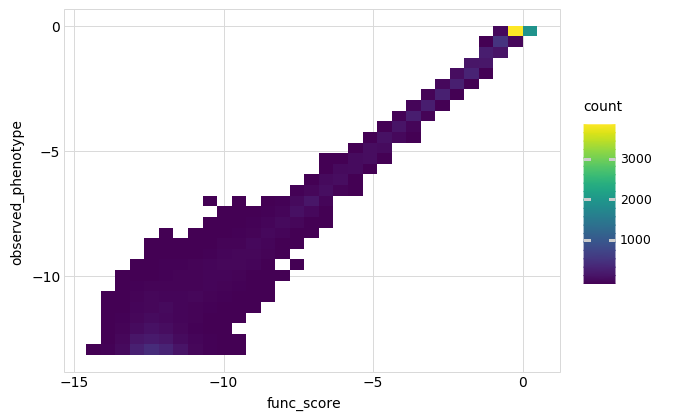

In [49]:
_ = (ggplot(variants_df, aes('func_score', 'observed_phenotype')) + 
     geom_bin2d()
     ).draw()

In [50]:
(variants_df
 [['func_score', 'latent_phenotype', 'observed_phenotype']]
 .corr()
 .round(3)
 )

,func_score,latent_phenotype,observed_phenotype
func_score,1.000,0.913,0.994
latent_phenotype,0.913,1.000,0.932
observed_phenotype,0.994,0.932,1.000
